In [1]:
cd ..

c:\Users\jeong\Desktop\python-practices\contrastive-triplet-practice


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.cuda
import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils
import torch.utils.data
import torchvision
import torchvision.transforms

import reid.datasets.paired
import reid.losses
import reid.models
import reid.utilities

In [3]:
# Get Device
device = reid.utilities.device()
reid.utilities.manual_seed(777)

In [4]:
# Prepare Datasets
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
transform_inv = torchvision.transforms.Compose([
    # torchvision.transforms.Normalize((-1, -1, -1), (2, 2, 2)),
])

dataset = torchvision.datasets.Omniglot('./data/omniglot', transform=transform, download=True)
dataset_train = reid.datasets.paired.TriplePairedVisionDataset(
    dataset)
dataloader_train = torch.utils.data.DataLoader(dataset_train,
                                               batch_size=64*4,
                                               shuffle=True,
                                               num_workers=0)

Files already downloaded and verified


In [5]:
# Create Model
model = reid.models.simple_cnn()
model.to(device)
criterion = torch.nn.TripletMarginLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_sche = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [6]:
# Or Load
# model = reid.models.resnet18_custom(False)
# model.load_state_dict(torch.load('./model_epoch_49.pth'))
# model = model.to(device).eval()

In [7]:
# Train
loss_epoch = []
num_epochs = 30
for epoch in range(num_epochs):
    loss_batch = 0.0
    for i, batch in enumerate(dataloader_train, 0):
        inputs_anchor, inputs_positive, inputs_negative = batch
        inputs_anchor = inputs_anchor.to(device)
        inputs_positive = inputs_positive.to(device)
        inputs_negative = inputs_negative.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs_anchor = model(inputs_anchor)
        outputs_positive = model(inputs_positive)
        outputs_negative = model(inputs_negative)
        loss: torch.Tensor = criterion(outputs_anchor, outputs_positive,
                                       outputs_negative)
        loss.backward()
        optimizer.step()

        # print statistics
        loss_batch += loss
    lr_sche.step()
    loss_batch /= i+1
    print(f'epoch: {epoch}, loss: {loss_batch}')
    loss_epoch.append(loss_batch)

    if epoch % 10 == 9:
        reid.utilities.save_model(model, f'triplet_simple_omni_{epoch}')

epoch: 0, loss: 0.4696350693702698
epoch: 1, loss: 0.25450462102890015
epoch: 2, loss: 0.21443156898021698
epoch: 3, loss: 0.21043862402439117
epoch: 4, loss: 0.18392765522003174
epoch: 5, loss: 0.16119007766246796
epoch: 6, loss: 0.1386360228061676
epoch: 7, loss: 0.12597082555294037
epoch: 8, loss: 0.1230178102850914
epoch: 9, loss: 0.12646326422691345
epoch: 10, loss: 0.11201421916484833
epoch: 11, loss: 0.1033235713839531
epoch: 12, loss: 0.09412084519863129
epoch: 13, loss: 0.0881238579750061
epoch: 14, loss: 0.08350950479507446
epoch: 15, loss: 0.08072230219841003
epoch: 16, loss: 0.07828675210475922
epoch: 17, loss: 0.07632044702768326
epoch: 18, loss: 0.0765790194272995
epoch: 19, loss: 0.07223246991634369
epoch: 20, loss: 0.07334911823272705
epoch: 21, loss: 0.06528455018997192
epoch: 22, loss: 0.06257397681474686
epoch: 23, loss: 0.0605786107480526
epoch: 24, loss: 0.05953943729400635
epoch: 25, loss: 0.054085198789834976
epoch: 26, loss: 0.05740075930953026
epoch: 27, loss: 

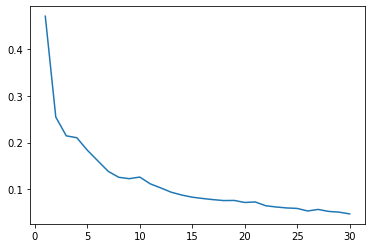

In [8]:
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), loss_epoch)
plt.show()

In [9]:
# Test
def visualize_batch(model, batch, transform, device):
    anchors, others, labels = batch
    anchors, positives, negatives = batch

    for i in range(len(anchors)):
        anchor = anchors[i].unsqueeze(dim=0).to(device)
        positive = positives[i].unsqueeze(dim=0).to(device)
        negative = negatives[i].unsqueeze(dim=0).to(device)

        # calc distance between anchor and X
        output_anchor = model(anchor)
        output_positive = model(positive)
        output_negative = model(negative)
        distance_positive = torch.nn.functional.pairwise_distance(
            output_anchor, output_positive)
        distance_negative = torch.nn.functional.pairwise_distance(
            output_anchor, output_negative)

        # make grid
        imgs = torch.cat(
            (transform(anchor), transform(positive), transform(negative)), 0)
        plt.imshow(torchvision.utils.make_grid(imgs).cpu().permute(1, 2, 0))
        plt.text(75,
                 8,
                 'p: {:.2f}, n: {:.2f}'.format(distance_positive.item(),
                                               distance_negative.item()),
                 fontweight='bold',
                 bbox={
                     'facecolor': 'white',
                     'alpha': 0.8,
                     'pad': 10
                 })
        plt.show()

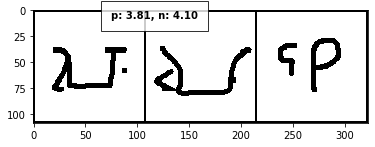

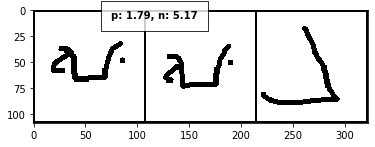

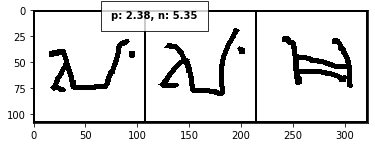

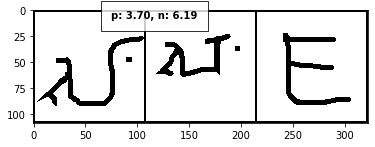

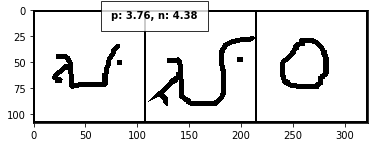

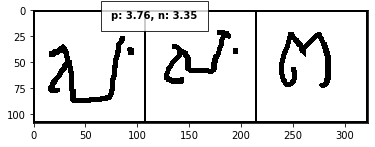

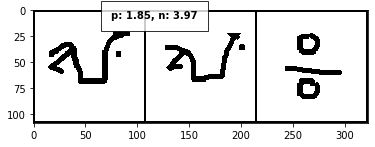

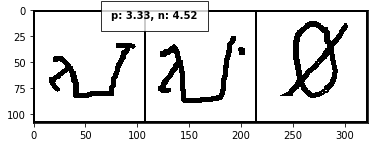

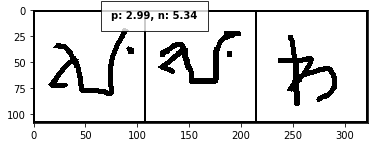

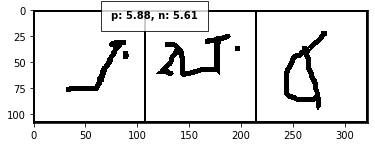

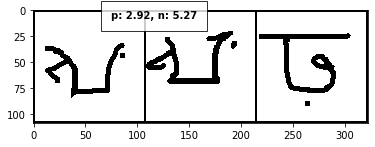

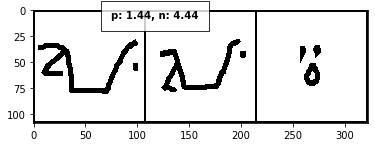

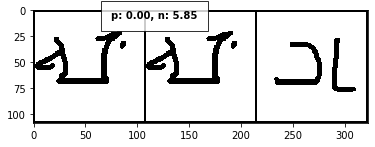

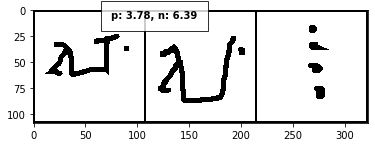

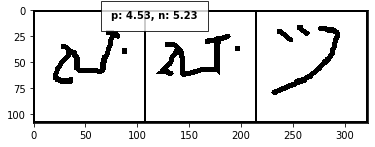

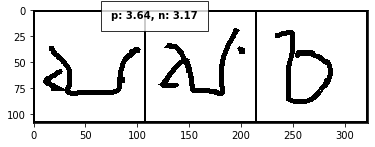

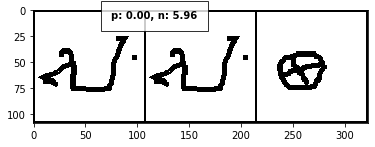

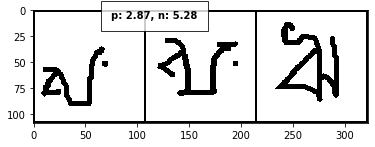

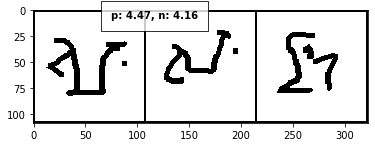

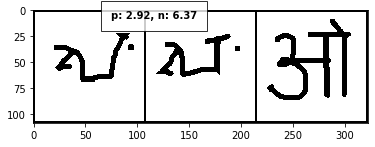

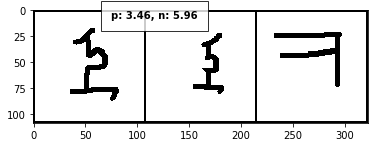

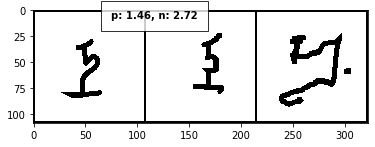

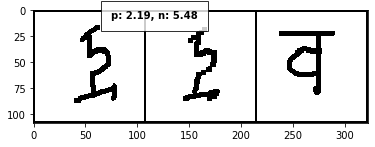

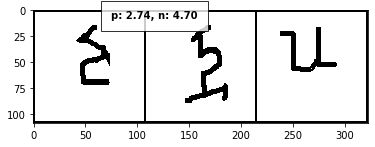

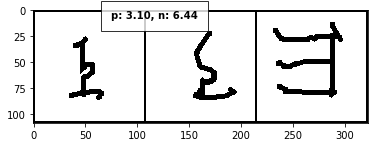

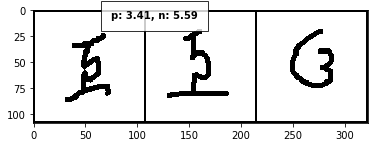

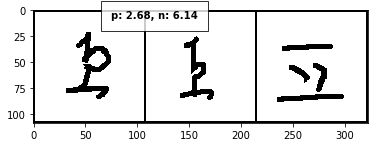

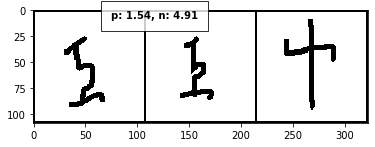

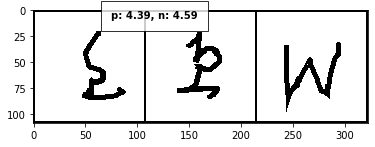

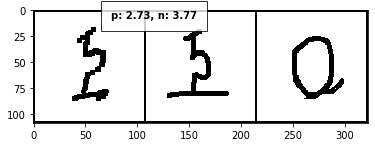

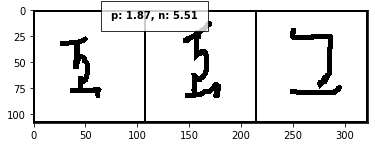

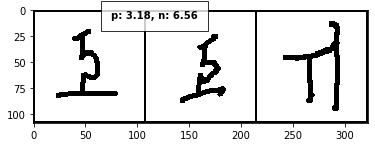

In [10]:
dataloader_test = torch.utils.data.DataLoader(dataset_train,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=0)
batch = next(iter(dataloader_test))
visualize_batch(model, batch, transform_inv, device)

In [11]:
f'classes: {len(dataset_train._classes)}, size: {len(dataset_train)}'

'classes: 964, size: 19280'